In [1]:
import sys
sys.path.append("../../code")

In [2]:
import gen

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y
    
    # function to extact the multiple features
    def feature_list(self, x):
        out_list = []
        out = F.relu(self.bn1(self.conv1(x)))
        out_list.append(out)
        out = self.layer1(out)
        out_list.append(out)
        out = self.layer2(out)
        out_list.append(out)
        out = self.layer3(out)
        out_list.append(out)
        out = self.layer4(out)
        out_list.append(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y, out_list
    
    # function to extact a specific feature
    def intermediate_forward(self, x, layer_index):
        out = F.relu(self.bn1(self.conv1(x)))
        if layer_index == 1:
            out = self.layer1(out)
        elif layer_index == 2:
            out = self.layer1(out)
            out = self.layer2(out)
        elif layer_index == 3:
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
        elif layer_index == 4:
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)               
        return out

    # function to extact the penultimate features
    def penultimate_forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        penultimate = self.layer4(out)
        out = F.avg_pool2d(penultimate, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y, penultimate

def ResNet9():
    return ResNet(BasicBlock, [1,1,1,1], num_classes=10)
    
def ResNet18():
    return ResNet(PreActBlock, [2,2,2,2], num_classes=10)

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3], num_classes=10)

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3], num_classes=10)

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3], num_classes=10)

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3], num_classes=10)

In [5]:
train_model = ResNet9()

In [6]:
#adv_train(data_set, adv_sample_path, sample_num, sample_shape, train_model, model_lossfun, model_optimizer, config, METHOD_dataset_NET_TNET)
data_set = 'cifar10'
adv_sample_path = '../sample/PGD_cifar10_ResNet9/train'
sample_num = 50000
sample_shape = [3,32,32]
model_lossfun = nn.CrossEntropyLoss()
model_optimizer = optim.SGD(train_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
config = 'PGD_cifar10_ResNet9_ResNet9.json'
METHOD_dataset_NET_TNET = 'PGD_cifar10_ResNet9_ResNet9'

In [7]:
gen.adv_train(
    data_set, 
    adv_sample_path, 
    sample_num, 
    sample_shape, 
    train_model, 
    model_lossfun, 
    model_optimizer, 
    config, 
    METHOD_dataset_NET_TNET)

epoch:0/100
loss:16.63153267,cost:65.2902s
epoch:1/100
loss:11.37492180,cost:65.2262s
epoch:2/100
loss:8.91507530,cost:63.0501s
epoch:3/100
loss:6.82214689,cost:61.9796s
epoch:4/100
loss:4.83171082,cost:62.4379s
epoch:5/100
loss:3.26103377,cost:65.2487s
epoch:6/100
loss:2.22159076,cost:65.8076s
epoch:7/100
loss:1.51519370,cost:64.6799s
epoch:8/100
loss:0.98424429,cost:64.8354s
epoch:9/100
loss:0.58128530,cost:64.9272s
epoch:10/100
loss:0.29980877,cost:65.8459s
epoch:11/100
loss:0.10217580,cost:65.4832s
epoch:12/100
loss:0.03864113,cost:64.9991s
epoch:13/100
loss:0.02331763,cost:64.6710s
epoch:14/100
loss:0.01864320,cost:63.1573s
epoch:15/100
loss:0.01588590,cost:64.0777s
epoch:16/100
loss:0.01395577,cost:64.6874s
epoch:17/100
loss:0.01250414,cost:64.0980s
epoch:18/100
loss:0.01136624,cost:65.6389s
epoch:19/100
loss:0.01044453,cost:65.2044s
epoch:20/100
loss:0.00967980,cost:64.8559s
epoch:21/100
loss:0.00903259,cost:65.0721s
epoch:22/100
loss:0.00847922,cost:64.8810s
epoch:23/100
loss:0

In [7]:
import val

In [8]:
adv_model = torch.load('../model/adv_train/PGD_cifar10_ResNet9_ResNet9/model.pkl')

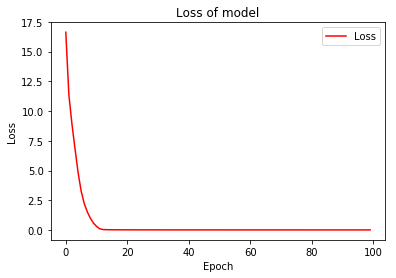

In [9]:
# make_loss_curve(loss_file, file_type)
val.make_loss_curve(
    loss_file = '../model/adv_train/PGD_cifar10_ResNet9_ResNet9/loss.txt',
    file_type = 'adv_train')

In [10]:
import tst

In [11]:
tst.accuracy_test(
    model = adv_model, 
    data_set = 'cifar10'
    )

accuracy:75.820000%


## FGSM

In [12]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/FGSM_cifar10_CNN/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:45.930000%


In [13]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/FGSM_cifar10_ResNet9/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:13.150000%


In [14]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/FGSM_cifar10_ResNet34/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:47.510000%


## JSMA

In [15]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/JSMA_cifar10_CNN/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:81.370000%


In [16]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/JSMA_cifar10_ResNet9/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:79.830000%


In [17]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/JSMA_cifar10_ResNet34/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:57.310000%


## DEEPFOOL

In [18]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/DEEPFOOL_cifar10_CNN/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:29.300000%


In [19]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/DEEPFOOL_cifar10_ResNet9/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:17.970000%


In [20]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/DEEPFOOL_cifar10_ResNet34/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:30.110000%


## PGD

In [21]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/PGD_cifar10_CNN/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:25.330000%


In [22]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/PGD_cifar10_ResNet9/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:16.980000%


In [23]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/PGD_cifar10_ResNet34/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:25.740000%


## THREAT

In [24]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/THREAT_cifar10/test',
    sample_num = 10000,
    sample_shape = [3,32,32]
)

fooling_rate:59.210000%
